In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_pickle('train.pkl')

In [3]:
test=pd.read_pickle('test.pkl')

In [4]:
df=train.copy()

game_id : 경기 구분 기호
winner : player 1의 승리 확률
time : 경기 시간, 마침표(.)로 분과 초가 구분됩니다. ex) 2.24 = 2분 24초+ player : 선수

#### 1) 0: player 0
#### 2) 1: player 1
+ species : 종족
#### 1) T: 테란 :0
#### 2) P: 프로토스 :1
#### 3) Z: 저그:2
+ event : 행동 종류
+ event_contents : 행동 상세

#### 1) Ability : 생산, 공격 등 선수의 주요 행동

#### 2) AddToControlGroup : 부대에 추가

#### 3) Camera : 시점 선택

#### 4) ControlGroup : 부대 행동

#### 5) GetControlGroup : 부대 불러오기

#### 6) Right Click : 마우스 우클릭

#### 7) Selection : 객체 선택

#### 8) SetControlGroup : 부대 지정
'Camera': 0, '
Selection': 1, 
'Ability': 2, 
'Right Click': 3, 
'SetControlGroup': 4, 
'GetControlGroup': 5, 
'AddToControlGroup': 6, 
'ControlGroup': 7

+ sample_submission.csv

#### game_id : 경기 구분 기호

#### winner : player 1의 승리 확률

In [6]:
df.describe()

,game_id,winner,time,player,species,event
count,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07
mean,1.861381e+04,5.011006e-01,3.984620e+00,4.993334e-01,9.155748e-01,1.557664e+00
std,1.074859e+04,4.999988e-01,2.708632e+00,4.999996e-01,8.590866e-01,1.849485e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.294000e+03,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.863300e+04,1.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
75%,2.794300e+04,1.000000e+00,6.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00
max,3.721700e+04,1.000000e+00,1.000000e+01,1.000000e+00,2.000000e+00,7.000000e+00


In [6]:
df.isnull().sum()

game_id                  0
winner                   0
time                     0
player                   0
species                  0
event                    0
event_contents    10114089
dtype: int64

event_contents에만 결측값이 확인됨. 생산, 공격, 카메라등의 행동이 담겨있는 변수임.

In [5]:
null_rows = df[df.isnull().any(axis=1)]

df_null=pd.DataFrame(null_rows)
df_null['event'].unique()

array([4, 5, 6, 7], dtype=uint8)

'SetControlGroup': 4, 'GetControlGroup': 5, 'AddToControlGroup': 6, 'ControlGroup': 7 이므로 각 ControlGroup하는 행동들에 결측값이 보임.

In [8]:
print(df['game_id'].unique())
print(df['winner'].unique())
print(df['time'].unique())
print(df['player'].unique())
print(df['species'].unique())
print(df['event'].unique())

[    0     1     2 ... 37215 37216 37217]
[1 0]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1]
[0 1 2]
[0 1 2 3 4 5 6 7]


특정값이나 이상값이 관측되지 않음.

### 데이터 전처리

In [9]:
df['event_contents']

0                  at (145.25, 21.5078125)
1                  at (22.75, 147.0078125)
2             ['OrbitalCommand [3080001]']
3                        (1360) - TrainSCV
4           at (142.99609375, 24.50390625)
                         ...              
64204072                               NaN
64204073                               NaN
64204074    at (100.25390625, 103.9921875)
64204075                               NaN
64204076               ['Probe [3580001]']
Name: event_contents, Length: 64204077, dtype: object

형태가 매우 복잡함. 정규표현식을 통해 정리.

In [ ]:
position_data = df['event_contents'].str.extract(r'at \(([\d.]+),\s*([\d.]+)\)')
df['x_position'] = position_data[0].astype(float)
df['y_position'] = position_data[1].astype(float)

# 유닛 정보 추출
df['unit'] = df['event_contents'].str.extract(r'\[([^]]+)\]')

# 행동 정보 추출
action_data = df['event_contents'].str.extract(r'\((\d+)\) - (.+)')
df['action_name'] = action_data[1]

In [11]:
def extract_location(event_content):
    match = re.search(r'Location: \(([\d.]+), ([\d.]+), (\d+)\)', event_content)
    if match:
        return match.groups()
    else:
        return '(nan,nan,nan)'

# 'Attack' 열이 있는 경우에만 좌표 정보 추출
df['Attack'] = df[df['event_contents'].str.contains('Attack', na=False)]['event_contents'].apply(extract_location)
df

,game_id,winner,time,player,species,event,event_contents,x_position,y_position,unit,action_name,Attack
0,0,1,0,0,0,0,"at (145.25, 21.5078125)",145.250000,21.507812,NaN,NaN,NaN
1,0,1,0,1,0,0,"at (22.75, 147.0078125)",22.750000,147.007812,NaN,NaN,NaN
2,0,1,0,0,0,1,['OrbitalCommand [3080001]'],NaN,NaN,'OrbitalCommand [3080001,NaN,NaN
3,0,1,0,0,0,2,(1360) - TrainSCV,NaN,NaN,NaN,TrainSCV,NaN
4,0,1,0,0,0,0,"at (142.99609375, 24.50390625)",142.996094,24.503906,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
64204072,37217,1,1,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN
64204073,37217,1,1,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN
64204074,37217,1,1,1,1,0,"at (100.25390625, 103.9921875)",100.253906,103.992188,NaN,NaN,NaN
64204075,37217,1,1,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['x_position_0'] = df.loc[df['event'] == 0, 'x_position']
df['y_position_0'] = df.loc[df['event'] == 0, 'y_position']

# 'event'가 3일 때의 위치를 새로운 열로 추가
df['x_position_3'] = df.loc[df['event'] == 3, 'x_position']
df['y_position_3'] = df.loc[df['event'] == 3, 'y_position']

df

### 데이터 game_id별 정리 (전체적인 데이터 구조를 살펴보기위해..)

In [114]:
#게임id별 winner
df_train = pd.DataFrame(columns=['game_id'])
df_train.game_id = train.game_id.unique()
df_train['winner'] = np.array(train[train.shift(-1).game_id != train.game_id].winner)

In [115]:
#시간 열 추가
df_train['time'] = np.array(train[train.shift(-1).game_id != train.game_id].time)

In [116]:
#종족열 추가
df_x = train[train.player==0]
df_train['player0_species']=np.array(df_x[df_x.shift(-1).game_id != df_x.game_id].species)
df_x = train[train.player==1]
df_train['player1_species']=np.array(df_x[df_x.shift(-1).game_id != df_x.game_id].species)

In [117]:
#이벤트 카운트 열
df_x = train[train.player==0]
df_train['event_count_0'] = np.array(df_x.game_id.value_counts()[df_x.game_id.unique()])
df_x = train[train.player==1]
df_train['event_count_1'] = np.array(df_x.game_id.value_counts()[df_x.game_id.unique()])

In [118]:
ev_co={0: 'Camera', 1: 'Selection', 2: 'Ability', 3: 'Right Click', 4: 'SetControlGroup', 5: 'GetControlGroup', 6: 'AddToControlGroup', 7: 'ControlGroup'}

In [119]:
for event in train.event.unique():
    df_x = train[(train.player==0)&(train.event==event)]
    df_x = pd.DataFrame(df_x.game_id.value_counts()[df_x.game_id.unique()]).rename({'game_id':ev_co[event]+'_count_0'}, axis = 1)
    df_x['game_id']= np.array(df_x.index)
    df_train = pd.merge(df_train, df_x, on='game_id', how='left')

    df_x = train[(train.player==1)&(train.event==event)]
    df_x = pd.DataFrame(df_x.game_id.value_counts()[df_x.game_id.unique()]).rename({'game_id':ev_co[event]+'_count_1'}, axis = 1)
    df_x['game_id']= np.array(df_x.index)
    df_train = pd.merge(df_train, df_x, on='game_id', how='left')
df_train = df_train.fillna(0)

In [120]:
for event in train.event.unique():
    df_train[ev_co[event] + '_diff'] = df_train[ev_co[event]+'_count_0'] - df_train[ev_co[event]+'_count_1']

In [121]:
#event차이
df_train['event_diff']=df_train['event_count_0']-df_train['event_count_1']

In [122]:
#승률 계산을 위해 승자 종족이 누구인지
df_train['winner_species'] = df_train.apply(lambda row: row['player0_species'] if row['winner'] == 0 else row['player1_species'], axis=1)
df_train['winner_species'] = df_train['winner_species'].astype(int)

In [123]:
df_train['Attack_count'] =df.groupby('game_id')['Attack'].count()

In [124]:
import numpy as np

# 0이 아닌 마지막 값을 가져오는 함수
def get_last_nonzero_attack(x):
    x = x.dropna()
    if not x.empty:
        last_nonzero = x[x != 0]
        if not last_nonzero.empty:
            return last_nonzero.iloc[-1]
    return np.nan

df_train['Last_Attack'] = df.groupby('game_id')['Attack'].apply(get_last_nonzero_attack)


In [125]:
df_train

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,Attack_count,Last_Attack
0,0,1,7,0,0,592,548,444.0,425.0,50.0,...,0.0,7.0,2.0,21.0,2.0,0.0,44,0,3,"(28.266357421875, 122.27685546875, 40935)"
1,1,1,9,1,0,1223,1211,627.0,858.0,186.0,...,10.0,29.0,2.0,131.0,1.0,0.0,12,0,6,"(37.140869140625, 47.5185546875, 40929)"
2,2,0,9,1,2,851,1371,413.0,725.0,90.0,...,-16.0,-44.0,5.0,-10.0,1.0,-2.0,-520,1,18,"(54.7626953125, 103.628662109375, 32748)"
3,3,0,9,0,1,1389,1622,713.0,388.0,180.0,...,-7.0,8.0,-13.0,-578.0,0.0,0.0,-233,0,25,"(122.658447265625, 54.605712890625, 56356)"
4,4,0,5,0,2,966,651,430.0,272.0,67.0,...,21.0,71.0,2.0,125.0,-3.0,0.0,315,0,16,"(55.038818359375, 116.45654296875, 46872)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37213,37213,1,9,2,0,661,1226,344.0,731.0,167.0,...,-36.0,-132.0,-1.0,-57.0,-3.0,0.0,-565,0,17,"(47.311279296875, 127.938720703125, 49137)"
37214,37214,1,9,0,0,1036,1439,593.0,647.0,119.0,...,-21.0,-145.0,-9.0,-150.0,0.0,0.0,-403,0,59,"(90.146240234375, 82.214599609375, 32744)"
37215,37215,1,2,0,0,258,291,64.0,244.0,39.0,...,5.0,16.0,0.0,94.0,2.0,0.0,-33,0,0,NaN
37216,37216,0,6,0,2,1289,566,527.0,280.0,111.0,...,20.0,134.0,-2.0,341.0,5.0,0.0,723,0,12,"(60.875244140625, 111.19482421875, 32748)"


## 1. 단일 변수
### 1) 승리여부

1    18670
0    18548
Name: winner, dtype: int64

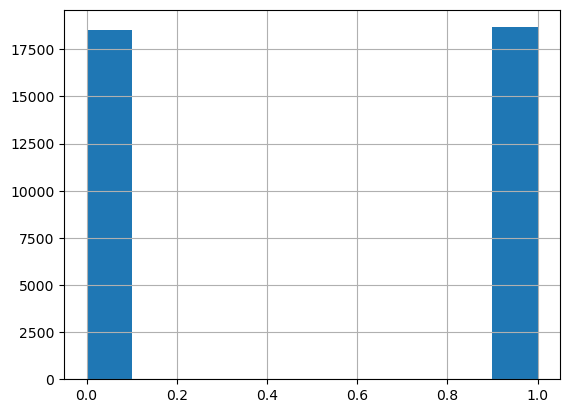

In [24]:
df_train.winner.hist()
df_train.winner.value_counts()

player0와 player1의 승리는 거의 같음. 타겟변수와는 큰 상관 없음.

### 2) 시간별

9     13198
8      3511
7      3470
6      3243
4      3134
5      3104
10     2785
3      2489
2      1287
1       612
0       385
Name: time, dtype: int64

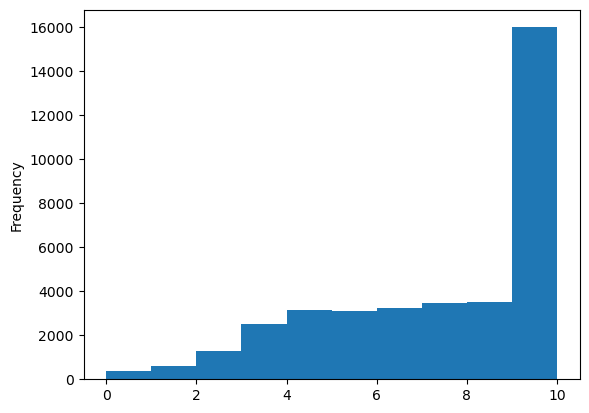

In [25]:
df_train.time.unique()
df_train.time.plot(kind='hist')
df_train.time.value_counts()

설명상 게임을 10분 전후로 끊은 데이터이기에 대부분 데이터가 9분에 몰렸음. 너무 작은 데이터의 이상치는?

In [26]:
df_train[(df_train['time'] == 0) | (df_train['time'] == 1)]

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,Attack_count,Last_Attack
88,88,0,1,1,0,33,46,16.0,31.0,3.0,...,0.0,1.0,2.0,1.0,0.0,0.0,-13,1,2,"(151.89892578125, 21.971435546875, 49100)"
143,143,1,1,2,1,229,141,72.0,83.0,27.0,...,2.0,24.0,1.0,54.0,0.0,0.0,88,1,0,NaN
182,182,1,1,0,0,106,208,47.0,86.0,11.0,...,-4.0,-20.0,-4.0,-23.0,0.0,0.0,-102,0,7,"(24.5, 147.5, 49120)"
187,187,0,0,2,2,70,30,22.0,0.0,25.0,...,0.0,-2.0,6.0,1.0,0.0,0.0,40,2,0,NaN
200,200,1,0,1,1,59,16,59.0,2.0,0.0,...,-1.0,-1.0,-2.0,-8.0,0.0,0.0,43,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37097,37097,1,1,2,2,130,169,53.0,89.0,28.0,...,1.0,4.0,0.0,0.0,0.0,0.0,-39,2,0,NaN
37171,37171,1,1,2,1,76,61,6.0,25.0,22.0,...,4.0,5.0,2.0,2.0,0.0,0.0,15,1,2,"(149.648193359375, 31.432373046875, 49127)"
37193,37193,0,0,1,0,37,33,18.0,13.0,11.0,...,-1.0,-3.0,0.0,5.0,0.0,0.0,4,1,0,NaN
37210,37210,1,0,0,2,16,127,6.0,20.0,2.0,...,0.0,-2.0,-2.0,-43.0,0.0,0.0,-111,2,0,NaN


<Axes: >

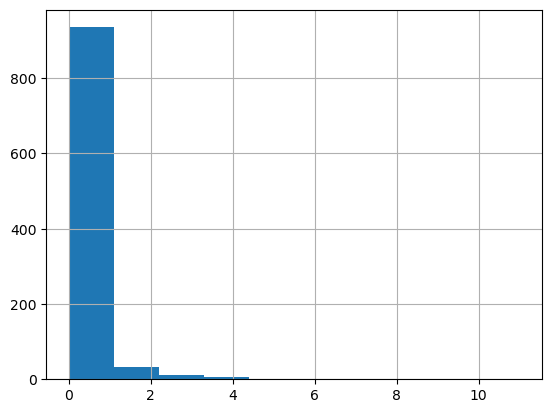

In [27]:
df_train[(df_train['time'] == 0) | (df_train['time'] == 1)]['Attack_count'].hist()

시간대가 엄청 빨리 끝난 0분대나 1분대는 startingpoint나 마지막 교전위치에 NaN값이 다수 있음. 또한 한번도 교전이 없는 데이터들은 이상치 데이터로 볼 수 있음. 0분대나 1분대 데이터들은 삭제해도 될거 같음. 

### 3) 종족별

0    14415
2    12370
1    10433
Name: player0_species, dtype: int64
0    14613
2    12136
1    10469
Name: player1_species, dtype: int64
0    29028
2    24506
1    20902
dtype: int64


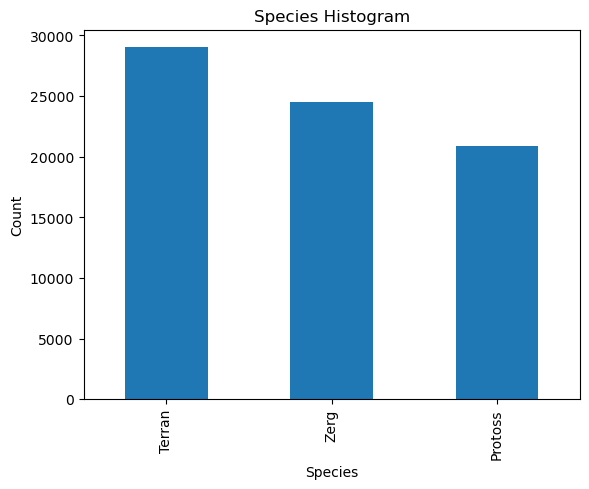

In [28]:
print(df_train['player0_species'].value_counts())
print(df_train['player1_species'].value_counts())

player0_species_count = df_train['player0_species'].value_counts()
player1_species_count = df_train['player1_species'].value_counts()

print(player0_species_count.add(player1_species_count, fill_value=0))
total_species_count = player0_species_count.add(player1_species_count, fill_value=0)
ax = total_species_count.plot(kind='bar', title='Species Histogram', xlabel='Species', ylabel='Count')

new_labels = ['Terran', 'Zerg', 'Protoss'] 
plt.xticks(range(len(new_labels)), new_labels)

plt.show()

테란이 가장 많음. ->시간대별 분포에 종족별 영향이 있을까

In [29]:
df_train.groupby('winner_species').mean().loc[:,'time':]

,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,Selection_count_1,Ability_count_0,...,Camera_diff,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,Attack_count
winner_species,,,,,,,,,,,,,,,,,,,,,
0,6.988662,0.478637,0.482508,894.318653,893.725664,422.822179,423.103291,116.260094,116.030282,52.555517,...,-0.281112,0.229812,-0.268529,0.460108,-0.016869,0.450982,0.010855,0.007743,0.592989,16.910537
1,6.874228,0.968533,0.958108,816.543533,817.044402,406.647394,406.299807,100.962066,99.667954,44.754247,...,0.347587,1.294112,-0.029440,-1.527124,-0.027413,-0.564768,0.001544,0.004633,-0.500869,12.171622
2,6.848152,1.469743,1.439083,867.356624,860.724141,389.917621,386.718170,148.846297,147.619897,47.642972,...,3.199451,1.226400,-0.031386,1.213975,-0.041391,1.078425,-0.013555,0.000565,6.632483,14.125222


테란이 저그나 프로토스에 비해 많은 게임 시간을 가져갔음. 게임 시간에 따른 영향이 있을듯.

In [30]:
subset0 = df_train[((df_train['player0_species'] == 0) & (df_train['player1_species'] == 2)) |
                ((df_train['player0_species'] == 2) & (df_train['player1_species'] == 0))]

subset1 = df_train[((df_train['player0_species'] == 0) & (df_train['player1_species'] == 1)) |
                ((df_train['player0_species'] == 1) & (df_train['player1_species'] == 0))]

subset2 = df_train[((df_train['player0_species'] == 1) & (df_train['player1_species'] == 2)) |
                ((df_train['player0_species'] == 2) & (df_train['player1_species'] == 1))]

In [31]:
t_win=len(subset0[subset0['winner_species'] == 0])/ len(subset0)
t_win1=len(subset1[subset1['winner_species'] == 0])/ len(subset1)
p_win1=len(subset1[subset1['winner_species'] == 1])/ len(subset1)
p_win2=len(subset2[subset2['winner_species'] == 1])/ len(subset2)
z_win=len(subset0[subset0['winner_species'] == 2])/len(subset0)
z_win2=len(subset2[subset2['winner_species'] == 2])/len(subset2)

In [32]:
print('T vs Z 승률','T 승률',round(t_win,4),'Z 승률', round(z_win,4))
print('T vs P 승률','T 승률',round(t_win1,4),'P 승률', round(p_win1,4))
print('P vs Z 승률','P 승률',round(p_win2,4),'Z 승률', round(z_win2,4))

T vs Z 승률 T 승률 0.4937 Z 승률 0.5063
T vs P 승률 T 승률 0.5015 P 승률 0.4985
P vs Z 승률 P 승률 0.4887 Z 승률 0.5113


저그는 테란과 프로토스 둘다보다 승률이 높음.
테란은 프로토스전에서 승률이 근소 우위임.
프로토스는 둘다에게 승률이 낮음.

=>데이터 패치 버전 당시에는 저그가 강한 모습을 보였음. 저그가 강함.

    Terran_win  Protoss_win
0           39           37
1           49           71
2          107          111
3          235          244
4          333          348
5          414          351
6          507          327
7          497          343
8          384          379
9         1323         1589
10         282          345


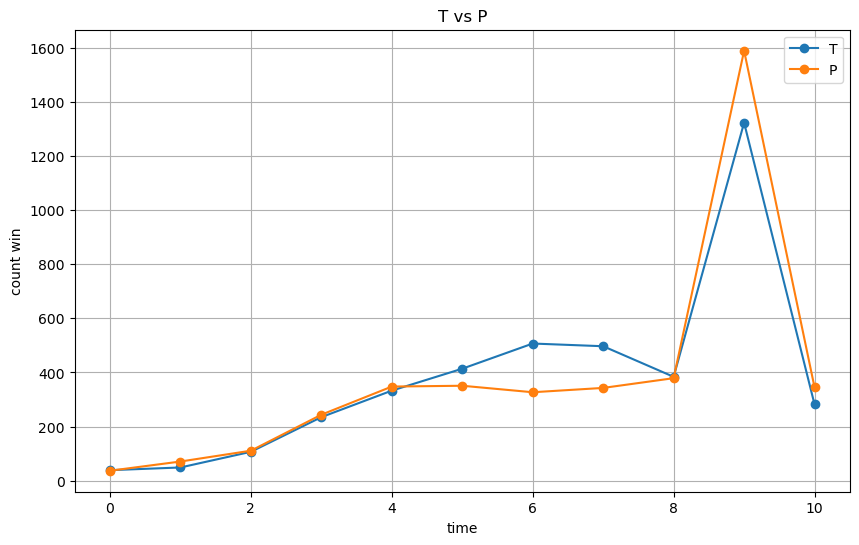

In [33]:
#T vs P

time_wins_species_TP = subset1[subset1['winner_species'] == 0].groupby('time')['winner_species'].count()
time_wins_species_PT = subset1[subset1['winner_species'] == 1].groupby('time')['winner_species'].count()

result_TP = pd.DataFrame({'Terran_win': time_wins_species_TP.values, 'Protoss_win': time_wins_species_PT.values})
print(result_TP)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_TP.index, time_wins_species_TP.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_PT.index, time_wins_species_PT.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('T vs P')
plt.legend(['T','P'])
plt.grid(True)

plt.show()

    Terran_win  Zerg_win
0           32        45
1           48        53
2          107       174
3          161       368
4          360       355
5          388       261
6          404       252
7          515       290
8          530       419
9         1945      2325
10         376       449


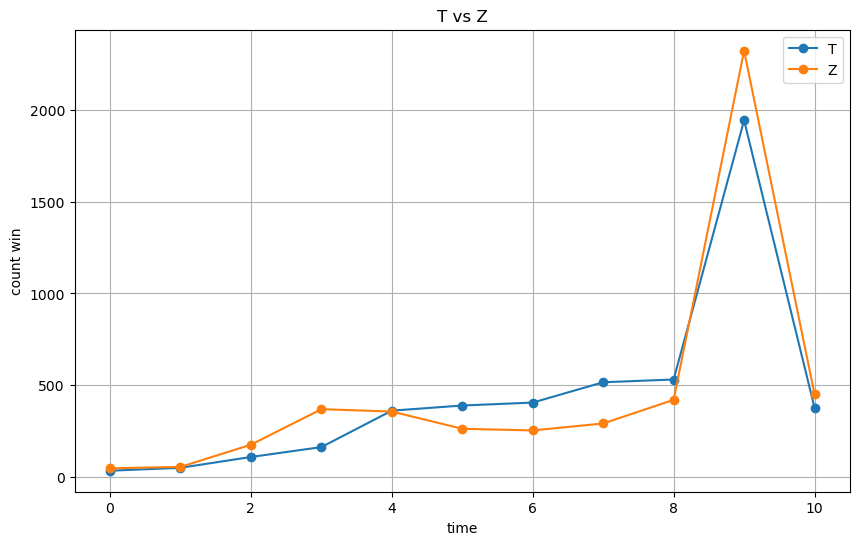

In [34]:
#T vs Z

time_wins_species_TZ = subset0[subset0['winner_species'] == 0].groupby('time')['winner_species'].count()
time_wins_species_ZT = subset0[subset0['winner_species'] == 2].groupby('time')['winner_species'].count()

result_TZ = pd.DataFrame({'Terran_win': time_wins_species_TZ.values, 'Zerg_win': time_wins_species_ZT.values})
print(result_TZ)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_TZ.index, time_wins_species_TZ.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_ZT.index, time_wins_species_ZT.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('T vs Z')
plt.legend(['T','Z'])
plt.grid(True)

plt.show()

    Terran_win  Zerg_win
0           32        45
1           48        53
2          107       174
3          161       368
4          360       355
5          388       261
6          404       252
7          515       290
8          530       419
9         1945      2325
10         376       449


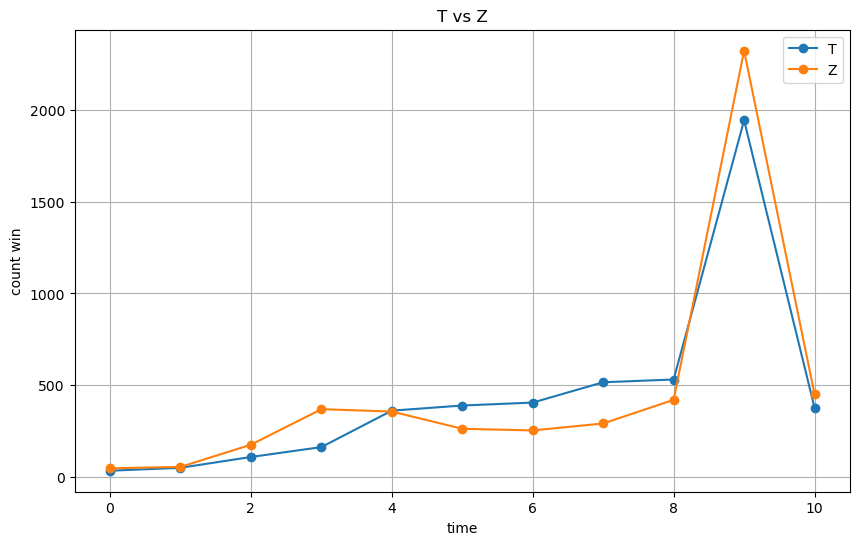

In [35]:
#T vs Z

time_wins_species_TZ = subset0[subset0['winner_species'] == 0].groupby('time')['winner_species'].count()
time_wins_species_ZT = subset0[subset0['winner_species'] == 2].groupby('time')['winner_species'].count()

result_TZ = pd.DataFrame({'Terran_win': time_wins_species_TZ.values, 'Zerg_win': time_wins_species_ZT.values})
print(result_TZ)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_TZ.index, time_wins_species_TZ.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_ZT.index, time_wins_species_ZT.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('T vs Z')
plt.legend(['T','Z'])
plt.grid(True)

plt.show()

각 종족별 대전에서 승률차이가 의미있게 보임. 각 종족을 변수로 활용하면 좋을듯.

### 4) Event 분석

In [36]:
df.event.value_counts()

0    30283223
3    11060802
5     9615850
1     9112777
2     3633186
4      325751
6      142871
7       29617
Name: event, dtype: int64

Camera',Right Click,'GetControlGroup','Selection','SetControlGroup','AddToControlGroup', 'ControlGroup'순임. 주요 행동은 Ability로 볼 수 있는데 나머지 변수는 필요한가? 카메라변수를 통해 시작 포인트, 교전지점 정도를 확인 할 수 있고 나머지는 의미있는가

In [37]:
df_train['adjusted_event_diff'] = df_train.apply(lambda row: row['event_diff'] if row['winner'] == 0 else -row['event_diff'], axis=1)

total_adjusted_event_diff = df_train[df_train['adjusted_event_diff'] > 0]['event_diff'].count()
winner_positive_ratio= total_adjusted_event_diff/df_train['event_diff'].count()

print(f"승자가 패자보다 많은 event를 한 경기의 비율: {winner_positive_ratio:.2%}")

승자가 패자보다 많은 event를 한 경기의 비율: 54.17%


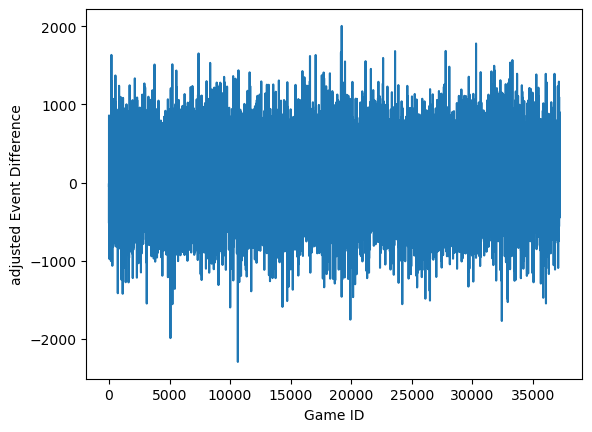

In [38]:
plt.plot(df_train['game_id'], df_train['adjusted_event_diff'])

plt.xlabel('Game ID')
plt.ylabel('adjusted Event Difference')
plt.show()

In [39]:
df_train.groupby('winner')['adjusted_event_diff'].mean()

winner
0    40.174628
1    35.327691
Name: adjusted_event_diff, dtype: float64

In [40]:
from scipy import stats

adjusted_event_diff = df_train['adjusted_event_diff']

# 귀무가설: 'adjusted_event_diff'의 평균은 0보다 크지 않다.
# 대립가설: 'adjusted_event_diff'의 평균은 0보다 크다.
alpha = 0.05  # 유의수준 설정
t_statistic, p_value = stats.ttest_1samp(adjusted_event_diff, 0, alternative='greater')

# p-값 출력
print("p-값:", p_value)

if p_value < alpha:
    print("귀무가설 기각: 'adjusted_event_diff'의 평균은 0보다 크다.")
else:
    print("귀무가설 채택: 'adjusted_event_diff'의 평균은 0보다 크지 않다.")

p-값: 1.608909720904409e-96
귀무가설 기각: 'adjusted_event_diff'의 평균은 0보다 크다.


### Attack 변수
#### 한경기 내내 attack이 한번도 없는건 이상치 데이터로 볼 수 있음.
#### attack을 통해 경기의 양상을 확인 할 수 있을듯.

In [76]:
df_train[df_train['Attack_count'] ==0]

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,Attack_count,Last_Attack
9,9,1,3,1,2,552,374,171.0,246.0,139.0,...,-1.0,72.0,2.0,94.0,-2.0,0.0,178,2,0,NaN
12,12,1,6,0,2,626,533,419.0,198.0,78.0,...,-2.0,-6.0,12.0,-77.0,-1.0,0.0,93,2,0,NaN
26,26,0,3,0,2,370,402,313.0,280.0,25.0,...,-3.0,7.0,-13.0,-16.0,0.0,0.0,-32,0,0,NaN
32,32,1,2,2,2,268,216,28.0,12.0,87.0,...,4.0,-16.0,2.0,-10.0,-2.0,0.0,52,2,0,NaN
33,33,0,3,2,2,496,526,105.0,78.0,88.0,...,-1.0,67.0,6.0,-122.0,-3.0,0.0,-30,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37178,37178,1,2,1,0,266,163,201.0,127.0,4.0,...,-2.0,28.0,0.0,14.0,0.0,0.0,103,0,0,NaN
37193,37193,0,0,1,0,37,33,18.0,13.0,11.0,...,-1.0,-3.0,0.0,5.0,0.0,0.0,4,1,0,NaN
37210,37210,1,0,0,2,16,127,6.0,20.0,2.0,...,0.0,-2.0,-2.0,-43.0,0.0,0.0,-111,2,0,NaN
37215,37215,1,2,0,0,258,291,64.0,244.0,39.0,...,5.0,16.0,0.0,94.0,2.0,0.0,-33,0,0,NaN


In [126]:
#Attack이 한번도 없는건 이상치 데이터로 볼수 있음.
df_train=df_train[df_train['Attack_count'] !=0]
df_train

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,Attack_count,Last_Attack
0,0,1,7,0,0,592,548,444.0,425.0,50.0,...,0.0,7.0,2.0,21.0,2.0,0.0,44,0,3,"(28.266357421875, 122.27685546875, 40935)"
1,1,1,9,1,0,1223,1211,627.0,858.0,186.0,...,10.0,29.0,2.0,131.0,1.0,0.0,12,0,6,"(37.140869140625, 47.5185546875, 40929)"
2,2,0,9,1,2,851,1371,413.0,725.0,90.0,...,-16.0,-44.0,5.0,-10.0,1.0,-2.0,-520,1,18,"(54.7626953125, 103.628662109375, 32748)"
3,3,0,9,0,1,1389,1622,713.0,388.0,180.0,...,-7.0,8.0,-13.0,-578.0,0.0,0.0,-233,0,25,"(122.658447265625, 54.605712890625, 56356)"
4,4,0,5,0,2,966,651,430.0,272.0,67.0,...,21.0,71.0,2.0,125.0,-3.0,0.0,315,0,16,"(55.038818359375, 116.45654296875, 46872)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37211,37211,0,9,0,0,1568,1261,578.0,372.0,144.0,...,-26.0,3.0,1.0,158.0,6.0,0.0,307,0,61,"(143.161376953125, 113.11376953125, 31624)"
37212,37212,1,9,0,2,659,1000,475.0,568.0,71.0,...,-24.0,-73.0,-8.0,-53.0,0.0,0.0,-341,2,8,"(78.136962890625, 93.005126953125, 32768)"
37213,37213,1,9,2,0,661,1226,344.0,731.0,167.0,...,-36.0,-132.0,-1.0,-57.0,-3.0,0.0,-565,0,17,"(47.311279296875, 127.938720703125, 49137)"
37214,37214,1,9,0,0,1036,1439,593.0,647.0,119.0,...,-21.0,-145.0,-9.0,-150.0,0.0,0.0,-403,0,59,"(90.146240234375, 82.214599609375, 32744)"


attack 횟수가 0인 데이터 삭제

### Camera 변수 => 시작지점, 맵을 알아낼수 있음.

In [78]:
#camera 변수를 통해 시작지점을 알아낼 수 있음. 클러스터링?

각 맵에 따라 유리한 종족들이 보임. 시간대와 같이 하나의 feature로 활용가능 할듯.

In [181]:
df_a = pd.DataFrame(train.game_id.unique(), columns=['game_id'])
df_a.index = df_a.game_id
df_a = df_a.drop(['game_id'], axis = 1)

In [182]:
df_a.head()

""
game_id
0
1
2
3
4


In [183]:
df_train_p0 = train[(train.event== 0)&(train.player==0)]
df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_train_p0 = df_train_p0.iloc[:, [0,6]].rename({'event_contents':'player0_starting'}, axis = 1)
df_train_p0.index = df_train_p0['game_id']
df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
df_a = pd.merge(df_a, df_train_p0, on='game_id', how='left')
del df_train_p0

df_train_p1 = train[(train.event== 0)&(train.player==1)]
df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
df_train_p1 = df_train_p1.iloc[:, [0,6]].rename({'event_contents':'player1_starting'}, axis = 1)
df_train_p1.index = df_train_p1['game_id']
df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
df_a = pd.merge(df_a, df_train_p1, on='game_id', how='left')
del df_train_p1

In [184]:
df_a.head()

,player0_starting,player1_starting
game_id,,
0,"at (145.25, 21.5078125)","at (22.75, 147.0078125)"
1,"at (140.0, 162.0078125)","at (28.0, 18.5078125)"
2,"at (151.25, 20.5078125)","at (24.75, 128.0078125)"
3,"at (127.25, 27.5078125)","at (24.75, 137.0078125)"
4,"at (36.75, 122.0078125)","at (163.25, 18.5078125)"


In [185]:
df_a['player0_starting'] = df_a.player0_starting.str.split('(').str[1]
df_a['player0_starting'] = df_a.player0_starting.str.split(')').str[0]
split_xy = df_a.player0_starting.str.split(',')
df_a['player0_x'] = split_xy.str[0].astype('float')
df_a['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_a['player1_starting'] = df_a.player1_starting.str.split('(').str[1]
df_a['player1_starting'] = df_a.player1_starting.str.split(')').str[0]
split_xy = df_a.player1_starting.str.split(',')
df_a['player1_x'] = split_xy.str[0].astype('float')
df_a['player1_y'] = split_xy.str[1].astype('float')
del split_xy

In [186]:
df_a.head()

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y
game_id,,,,,,
0,"145.25, 21.5078125","22.75, 147.0078125",145.25,21.507812,22.75,147.007812
1,"140.0, 162.0078125","28.0, 18.5078125",140.00,162.007812,28.00,18.507812
2,"151.25, 20.5078125","24.75, 128.0078125",151.25,20.507812,24.75,128.007812
3,"127.25, 27.5078125","24.75, 137.0078125",127.25,27.507812,24.75,137.007812
4,"36.75, 122.0078125","163.25, 18.5078125",36.75,122.007812,163.25,18.507812


In [187]:
location_p0 = df_a.loc[:, ['player0_x', 'player0_y']]
location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_p1 = df_a.loc[:, ['player1_x', 'player1_y']]
location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_p1.index += location_p0.index[-1]+1

location = pd.concat([location_p0, location_p1])
location = location.dropna()
del location_p0, location_p1

In [188]:
location.head()

,location_x,location_y
game_id,,
0.0,145.25,21.507812
1.0,140.00,162.007812
2.0,151.25,20.507812
3.0,127.25,27.507812
4.0,36.75,122.007812


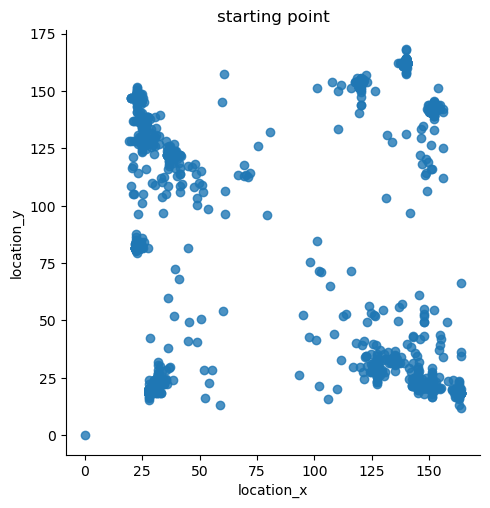

In [189]:
sns.lmplot(x='location_x', y='location_y', data = location, fit_reg=False)
plt.title('starting point')
plt.show()

In [190]:
df_a.player0_starting.value_counts().head(20)

24.75, 128.0078125          3002
22.75, 147.0078125          2963
145.25, 21.5078125          2931
151.25, 20.5078125          2920
152.25, 142.0078125         2597
31.75, 22.5078125           2540
24.75, 137.0078125          2514
127.25, 27.5078125          2479
163.25, 18.5078125          2346
28.0, 18.5078125            2300
140.0, 162.0078125          2259
36.75, 122.0078125          2182
135.25, 31.5078125          1168
22.25, 81.5078125           1160
120.25, 153.83984375        1153
36.74609375, 122.0078125     237
145.25, 21.51171875           62
24.75, 128.01171875           60
163.25, 18.51171875           55
151.25, 20.51171875           53
Name: player0_starting, dtype: int64

In [191]:
kmeans_clst = KMeans(n_clusters=15).fit(location)
location['starting'] = kmeans_clst.labels_+1

In [192]:
location.head()

,location_x,location_y,starting
game_id,,,
0.0,145.25,21.507812,2
1.0,140.00,162.007812,3
2.0,151.25,20.507812,13
3.0,127.25,27.507812,6
4.0,36.75,122.007812,7


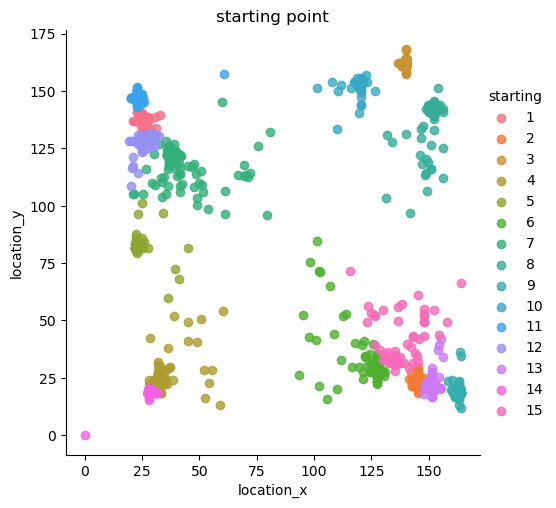

In [193]:
sns.lmplot(x='location_x', y='location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

In [194]:
for cluster in range(15):
    point = location[location.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location.loc[loc.index, 'distance'] = distance
    del loc

In [195]:
location.head()

,location_x,location_y,starting,distance
game_id,,,,
0.0,145.25,21.507812,2,0.031482
1.0,140.00,162.007812,3,0.022531
2.0,151.25,20.507812,13,0.041180
3.0,127.25,27.507812,6,0.144761
4.0,36.75,122.007812,7,0.144998


In [196]:
idx = location[location.distance>5].index
location.loc[idx, 'starting'] = 0
del idx

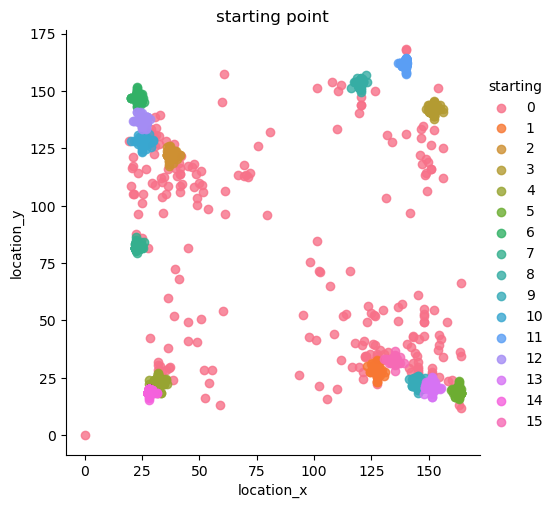

In [178]:
sns.lmplot(x='location_x', y='location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

In [197]:
df_a.drop([10246, 21149, 23337, 25891, 27818, 35288,187, 12105, 13292, 14675, 17294, 24423, 24855, 24858, 26243, 26339, 27249, 32254, 33101, 34423, 34843],axis=0, inplace=True)

In [198]:
df_a['player0_starting'] = location.loc[df_a.index, 'starting']
location.index -= (df_a.index[-1]+1)
df_a['player1_starting'] = location.loc[df_a.index, 'starting']
del location

# 불필요한 컬럼 삭제
df_a = df_a.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_a = df_a.fillna(0)

In [200]:
df_a.head()

,player0_starting,player1_starting
game_id,,
0,2,11
1,3,14
2,13,12
3,6,1
4,7,9


In [203]:
map_list = []
for point in range(1,16):
    couple = df_a[df_a.player0_starting == point].player1_starting.value_counts()
    if couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)

In [204]:
map_list

array([[  1,   6, 999],
       [  2,  11, 999],
       [  3,  14, 999],
       [  4,   8, 999],
       [  5,  10,  15],
       [  7,   9, 999],
       [ 12,  13, 999]], dtype=int64)

In [206]:
len(df_a[(df_a.player0_starting == 0)|(df_a.player1_starting == 0)])

227

In [207]:
for m in map_list:
    idx = df_a[(df_a.player0_starting == 0)&((df_a.player1_starting == m[0])|(df_a.player1_starting == m[2]))].index
    df_a.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_a[(df_a.player0_starting == 0)&((df_a.player1_starting == m[1])|(df_a.player1_starting == m[2]))].index
    df_a.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_a[(df_a.player1_starting == 0)&((df_a.player0_starting == m[0])|(df_a.player0_starting == m[2]))].index
    df_a.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_a[(df_a.player1_starting == 0)&((df_a.player0_starting == m[1])|(df_a.player0_starting == m[2]))].index
    df_a.loc[idx, 'player1_starting'] = m[0]
    del idx

In [208]:
df_a[(df_a.player0_starting == 0)|(df_a.player1_starting == 0)].head()

,player0_starting,player1_starting
game_id,,


In [209]:
for map_num, m in enumerate(map_list):
    idx = df_a[(df_a.player0_starting == m[0])|(df_a.player0_starting == m[1])|(df_a.player0_starting == m[2])].index
    df_a.loc[idx, 'map'] = map_num
del idx, map_list

In [210]:
df_a.head()

,player0_starting,player1_starting,map
game_id,,,
0,2,11,1.0
1,3,14,2.0
2,13,12,6.0
3,6,1,0.0
4,7,9,5.0


In [216]:
df_train = df_train.merge(df_a, on='game_id')

In [217]:
df_train

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,Attack_count,Last_Attack,player0_starting,player1_starting,map
0,0,1,7,0,0,592,548,444.0,425.0,50.0,...,21.0,2.0,0.0,44,0,3,"(28.266357421875, 122.27685546875, 40935)",2,11,1.0
1,1,1,9,1,0,1223,1211,627.0,858.0,186.0,...,131.0,1.0,0.0,12,0,6,"(37.140869140625, 47.5185546875, 40929)",3,14,2.0
2,2,0,9,1,2,851,1371,413.0,725.0,90.0,...,-10.0,1.0,-2.0,-520,1,18,"(54.7626953125, 103.628662109375, 32748)",13,12,6.0
3,3,0,9,0,1,1389,1622,713.0,388.0,180.0,...,-578.0,0.0,0.0,-233,0,25,"(122.658447265625, 54.605712890625, 56356)",6,1,0.0
4,4,0,5,0,2,966,651,430.0,272.0,67.0,...,125.0,-3.0,0.0,315,0,16,"(55.038818359375, 116.45654296875, 46872)",7,9,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32241,37211,0,9,0,0,1568,1261,578.0,372.0,144.0,...,158.0,6.0,0.0,307,0,61,"(143.161376953125, 113.11376953125, 31624)",14,3,2.0
32242,37212,1,9,0,2,659,1000,475.0,568.0,71.0,...,-53.0,0.0,0.0,-341,2,8,"(78.136962890625, 93.005126953125, 32768)",7,9,5.0
32243,37213,1,9,2,0,661,1226,344.0,731.0,167.0,...,-57.0,-3.0,0.0,-565,0,17,"(47.311279296875, 127.938720703125, 49137)",13,12,6.0
32244,37214,1,9,0,0,1036,1439,593.0,647.0,119.0,...,-150.0,0.0,0.0,-403,0,59,"(90.146240234375, 82.214599609375, 32744)",11,2,1.0


In [218]:
grouped = df_train.groupby('map')

results = []

# 각 'map'에 대한 T vs Z, T vs P, P vs Z 승률 계산
for map_name, group in grouped:
    subset0 = group[((group['player0_species'] == 0) & (group['player1_species'] == 2)) |
                    ((group['player0_species'] == 2) & (group['player1_species'] == 0))]

    subset1 = group[((group['player0_species'] == 0) & (group['player1_species'] == 1)) |
                    ((group['player0_species'] == 1) & (group['player1_species'] == 0))]

    subset2 = group[((group['player0_species'] == 1) & (group['player1_species'] == 2)) |
                    ((group['player0_species'] == 2) & (group['player1_species'] == 1))]

    t_win = len(subset0[subset0['winner_species'] == 0]) / len(subset0)
    t_win1 = len(subset1[subset1['winner_species'] == 0]) / len(subset1)
    p_win1 = len(subset1[subset1['winner_species'] == 1]) / len(subset1)
    p_win2 = len(subset2[subset2['winner_species'] == 1]) / len(subset2)
    z_win = len(subset0[subset0['winner_species'] == 2]) / len(subset0)
    z_win2 = len(subset2[subset2['winner_species'] == 2]) / len(subset2)

    results.append((map_name, t_win, t_win1, p_win1, p_win2, z_win, z_win2))

# 결과 출력
for result in results:
    map_name, t_win, t_win1, p_win1, p_win2, z_win, z_win2 = result
    print('Map', map_name)
    print('T vs Z 승률:', 'T 승률', round(t_win, 4), 'Z 승률', round(z_win, 4))
    print('T vs P 승률:', 'T 승률', round(t_win1, 4), 'P 승률', round(p_win1, 4))
    print('P vs Z 승률:', 'P 승률', round(p_win2, 4), 'Z 승률', round(z_win2, 4))

Map 0.0
T vs Z 승률: T 승률 0.5231 Z 승률 0.4769
T vs P 승률: T 승률 0.5173 P 승률 0.4827
P vs Z 승률: P 승률 0.4925 Z 승률 0.5075
Map 1.0
T vs Z 승률: T 승률 0.4623 Z 승률 0.5377
T vs P 승률: T 승률 0.4802 P 승률 0.5198
P vs Z 승률: P 승률 0.509 Z 승률 0.491
Map 2.0
T vs Z 승률: T 승률 0.5295 Z 승률 0.4705
T vs P 승률: T 승률 0.4888 P 승률 0.5112
P vs Z 승률: P 승률 0.518 Z 승률 0.482
Map 3.0
T vs Z 승률: T 승률 0.4774 Z 승률 0.5226
T vs P 승률: T 승률 0.4832 P 승률 0.5168
P vs Z 승률: P 승률 0.4934 Z 승률 0.5066
Map 4.0
T vs Z 승률: T 승률 0.5318 Z 승률 0.4682
T vs P 승률: T 승률 0.5038 P 승률 0.4962
P vs Z 승률: P 승률 0.4429 Z 승률 0.5571
Map 5.0
T vs Z 승률: T 승률 0.5095 Z 승률 0.4905
T vs P 승률: T 승률 0.5319 P 승률 0.4681
P vs Z 승률: P 승률 0.5012 Z 승률 0.4988
Map 6.0
T vs Z 승률: T 승률 0.4897 Z 승률 0.5103
T vs P 승률: T 승률 0.4952 P 승률 0.5048
P vs Z 승률: P 승률 0.4859 Z 승률 0.5141


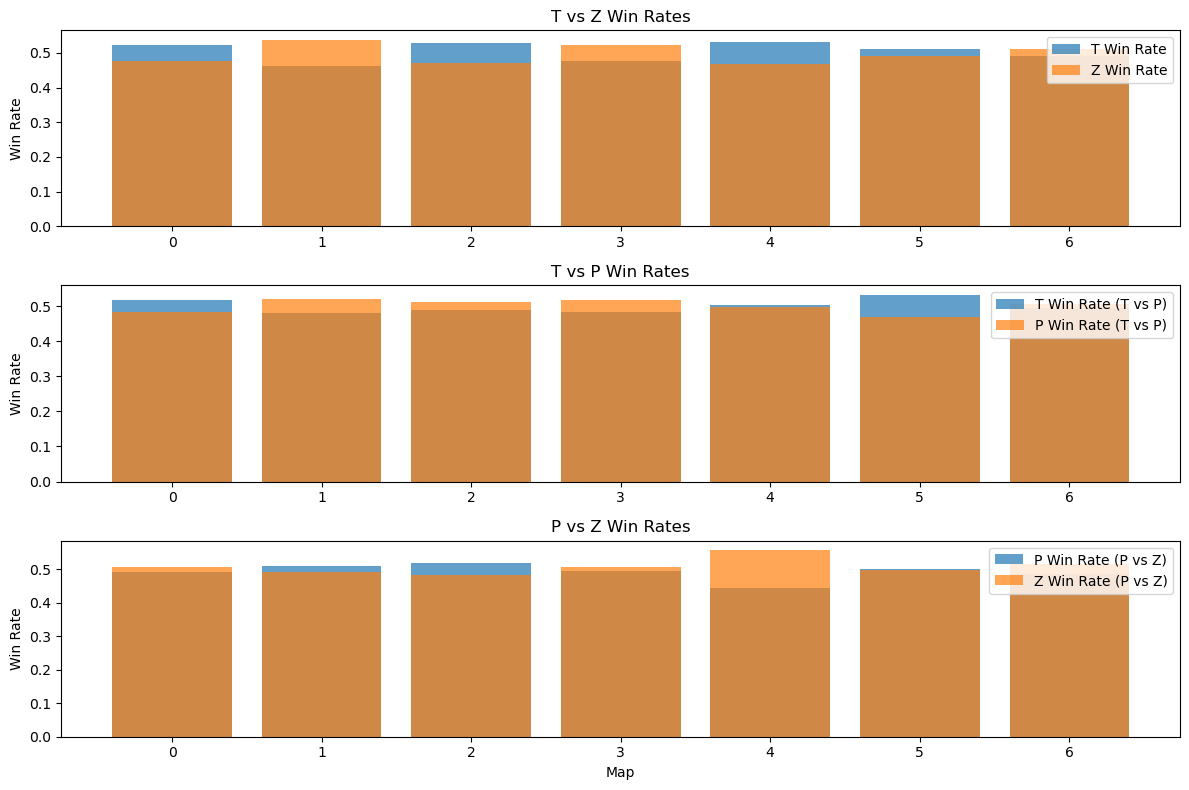

In [219]:
import matplotlib.pyplot as plt

# Results data
map_names = [result[0] for result in results]
t_win = [result[1] for result in results]
t_win1 = [result[2] for result in results]
p_win1 = [result[3] for result in results]
p_win2 = [result[4] for result in results]
z_win = [result[5] for result in results]
z_win2 = [result[6] for result in results]

# Create the plots
fig, ax = plt.subplots(figsize=(12, 8), nrows=3)

# T vs Z Win Rates
ax[0].bar(map_names, t_win, label='T Win Rate', alpha=0.7)
ax[0].bar(map_names, z_win, label='Z Win Rate', alpha=0.7)
ax[0].set_ylabel('Win Rate')
ax[0].set_title('T vs Z Win Rates')
ax[0].legend()

# T vs P Win Rates
ax[1].bar(map_names, t_win1, label='T Win Rate (T vs P)', alpha=0.7)
ax[1].bar(map_names, p_win1, label='P Win Rate (T vs P)', alpha=0.7)
ax[1].set_ylabel('Win Rate')
ax[1].set_title('T vs P Win Rates')
ax[1].legend()

# P vs Z Win Rates
ax[2].bar(map_names, p_win2, label='P Win Rate (P vs Z)', alpha=0.7)
ax[2].bar(map_names, z_win2, label='Z Win Rate (P vs Z)', alpha=0.7)
ax[2].set_xlabel('Map')
ax[2].set_ylabel('Win Rate')
ax[2].set_title('P vs Z Win Rates')
ax[2].legend()

plt.tight_layout()
plt.show()

### Last Attack위치와 이들의 시작점.

In [103]:
attack_location=pd.DataFrame(train.game_id.unique(),columns=['game_id'])
attack_location.index= attack_location.game_id
attack_location=attack_location.drop(['game_id'],axis=1)

In [104]:
df_train_p0 = df[(df.event== 0 )&(train.player==0)]
df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_train_p0 = df_train_p0.iloc[:, [0,6]].rename({'event_contents':'player0_starting'}, axis = 1)
df_train_p0.index = df_train_p0['game_id']
df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
attack_location = pd.merge(attack_location, df_train_p0, on='game_id', how='left')
del df_train_p0

df_train_p1 = df[(df.event==0)&(train.player==1)]
df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
df_train_p1 = df_train_p1.iloc[:, [0,6]].rename({'event_contents':'player1_starting'}, axis = 1)
df_train_p1.index = df_train_p1['game_id']
df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
attack_location = pd.merge(attack_location, df_train_p1, on='game_id', how='left')
del df_train_p1

In [105]:
attack_location = attack_location.merge(df_train[['game_id', 'Last_Attack']], on='game_id', how='left')

In [106]:
attack_location=attack_location.dropna(subset=['Last_Attack'])

In [107]:
attack_location['Last_Attack'] = attack_location['Last_Attack'].apply(lambda x: f"({x[0]}, {x[1]})")

attack_location = attack_location[['game_id', 'player0_starting', 'player1_starting', 'Last_Attack']]

In [108]:
def remove_pattern(text):
    return text.replace("((, n)", "")

# 패턴을 제거한 'Last_attack' 열 생성
attack_location['Last_Attack'] = attack_location['Last_Attack'].apply(remove_pattern)

In [109]:
def calculate_distance(coord1, coord2):
    if not coord1 or not coord2:
        return np.nan

    x1, y1 = map(float, re.findall(r"[-+]?\d*\.\d+|\d+", coord1))
    x2, y2 = map(float, re.findall(r"[-+]?\d*\.\d+|\d+", coord2))
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# 더 가까운 플레이어 결정 함수
def get_closer_player(row):
    player0_starting = row['player0_starting']
    player1_starting = row['player1_starting']
    last_attack = row['Last_Attack']

    distance_to_player0 = calculate_distance(player0_starting, last_attack)
    distance_to_player1 = calculate_distance(player1_starting, last_attack)

    if distance_to_player0 < distance_to_player1:
        return 0
    elif distance_to_player1 < distance_to_player0:
        return 1
    else:
        return "equal"

# 더 가까운 플레이어 열 추가
attack_location['Closer_Player'] = attack_location.apply(get_closer_player, axis=1)


In [110]:
# 더 멀리 있는 플레이어 결정 함수
def get_further_player(row):
    player0_starting = row['player0_starting']
    player1_starting = row['player1_starting']
    last_attack = row['Last_Attack']

    distance_to_player0 = calculate_distance(player0_starting, last_attack)
    distance_to_player1 = calculate_distance(player1_starting, last_attack)

    if distance_to_player0 > distance_to_player1:
        return 0  # player1 대신 player0으로 변경
    elif distance_to_player1 > distance_to_player0:
        return 1  # player0 대신 player1으로 변경
    else:
        return "equal"

# 더 멀리 있는 플레이어 열 추가
attack_location['Further_Player'] = attack_location.apply(get_further_player, axis=1)

attack_location = attack_location.merge(df_train[['game_id', 'winner']], on='game_id', how='left')
attack_location

,game_id,player0_starting,player1_starting,Last_Attack,Closer_Player,Further_Player,winner
0,0,"at (145.25, 21.5078125)","at (22.75, 147.0078125)","(28.266357421875, 122.27685546875)",1,0,1
1,1,"at (140.0, 162.0078125)","at (28.0, 18.5078125)","(37.140869140625, 47.5185546875)",1,0,1
2,2,"at (151.25, 20.5078125)","at (24.75, 128.0078125)","(54.7626953125, 103.628662109375)",1,0,0
3,3,"at (127.25, 27.5078125)","at (24.75, 137.0078125)","(122.658447265625, 54.605712890625)",0,1,0
4,4,"at (36.75, 122.0078125)","at (163.25, 18.5078125)","(55.038818359375, 116.45654296875)",0,1,0
...,...,...,...,...,...,...,...
32241,37211,"at (28.0, 18.5078125)","at (140.0, 162.0078125)","(143.161376953125, 113.11376953125)",1,0,0
32242,37212,"at (36.75, 122.0078125)","at (163.25, 18.5078125)","(78.136962890625, 93.005126953125)",0,1,1
32243,37213,"at (151.25, 20.5078125)","at (24.75, 128.0078125)","(47.311279296875, 127.938720703125)",1,0,1
32244,37214,"at (22.75, 147.0078125)","at (145.25, 21.5078125)","(90.146240234375, 82.214599609375)",1,0,1


In [111]:
# Further_Player와 winner가 같은 행을 필터링
same_player_count = len(attack_location[attack_location['Further_Player'] == attack_location['winner']])

# 전체 데이터의 개수
total_count = len(attack_location)

# 비율 계산
same_player_ratio = same_player_count / total_count

print(f'Further_Player와 winner가 같은 비율: {same_player_ratio:.2%}')

Further_Player와 winner가 같은 비율: 50.62%


* 마지막 교전위치와 승리와 큰 의미가 없어보임. 마지막 교전을 통해 역전한 경기도 많기 때문인거 같음. =>필요하면 가설검정?

* Last_Attack은 타겟변수와 큰 상관이 없을듯.

In [112]:
df_train.drop(['Last_Attack'],axis=1,inplace=True)

In [220]:
df_train.to_csv('df_train.csv', index=False)

## 인사이트
1. 타겟 변수에 영향을 많이 주는 종족별 데이터, 맵 위치 등은 핵심 변수가 될 가능성이 높음.
2. 종족별 경기별로 더 유리한 종족이 존재함 (저그가 다른 종족에 비해 유리한 모습을 보임.)
3. 시간대별로 구간화?

In [ ]:
#last_attack과 startpoint 거리계산? 이긴사람 기준으로 얼마나 되는지..
#attack=df_train[['game_id','Last_attack']]

In [ ]:
df_train['game_id'].unique()

In [ ]:
# 'game_id', 'player', 'extracted_action'를 그룹화하여 유닛 종류 수 세기
unit_df = df.groupby(['game_id', 'player', 'extracted_action'])['extracted_action'].count()

# 각 유닛 종류 수를 피벗테이블로 변환
unit_df = unit_df.unstack(fill_value=0)

# NaN 값을 0으로 채우기
unit_df = unit_df.fillna(0)

# 'player'를 열로 만들기
unit_df = unit_df.reset_index()

unit_df

In [ ]:
# 미네랄 및 가스 비용 딕셔너리
mineral_prices = {
    'SCV': 50,
    'SupplyDepot': 100,
    'Refinery': 75,
    'Barracks': 150,
    'CommandCenter': 400,
    'BarracksReactor': 50,
    'SiegeTank': 150,
    'EngineeringBay': 125,
    'WidowMine': 75,
    'Medivac': 100,
    'BarracksTechLab': 50,
    'Pylon': 100,
    'Gateway': 150,
    'Assimilator': 75,
    'Adept': 100,
    'MothershipCore': 100,
    'Forge': 150,
    'Nexus': 400,
    'TwilightCouncil': 150,
    'MissileTurret': 100,
    'Stalker': 125,
    'CreepTumor': 0,
    'FleetBeacon': 300,
    'PhotonCannon': 150,
    'Liberator': 150,
    'Hellion': 100,
    'Banshee': 150,
    'Zealot': 100,
    'Stargate': 150,
    'Bunker': 100,
    'Raven': 100,
    'Viking': 150,
    'Baneling': 50,
    'Cyclone': 150,
    'Sentry': 50,
    'AutoTurret': 0,
    'Thor': 400,
    'HighTemplar': 50,
    'SensorTower': 125,
    'GhostAcademy': 125,
    'NydusCanal': 150,
    'BattleHellion': 100,
    'Battlecruiser': 400,
    'Nuke': 100,
    'DarkTemplar': 125
}

gas_prices = {
    'SCV': 0,
    'SupplyDepot': 0,
    'Refinery': 0,
    'Barracks': 0,
    'CommandCenter': 0,
    'BarracksReactor': 50,
    'SiegeTank': 125,
    'EngineeringBay': 0,
    'WidowMine': 25,
    'Medivac': 100,
    'BarracksTechLab': 25,
    'Pylon': 0,
    'Gateway': 0,
    'Assimilator': 0,
    'Adept': 25,
    'MothershipCore': 100,
    'Forge': 100,
    'Nexus': 0,
    'TwilightCouncil': 100,
    'MissileTurret': 0,
    'Stalker': 50,
    'CreepTumor': 25,
    'FleetBeacon': 200,
    'PhotonCannon': 100,
    'Liberator': 150,
    'Hellion': 100,
    'Banshee': 100,
    'Zealot': 0,
    'Stargate': 150,
    'Bunker': 0,
    'Raven': 100,
    'Viking': 75,
    'Baneling': 25,
    'Cyclone': 100,
    'Sentry': 100,
    'AutoTurret': 100,
    'Thor': 200,
    'HighTemplar': 150,
    'SensorTower': 100,
    'GhostAcademy': 50,
    'NydusCanal': 0,
    'BattleHellion': 0,
    'Battlecruiser': 300,
    'Nuke': 100,
    'DarkTemplar': 125
}


In [ ]:
#game 별, player 별 미네랄과 가스 총 합 계산.

unit_df['TotalMineral'] = unit_df.apply(
    lambda row: sum(mineral_prices[unit] * row[unit] for unit in unit_df.columns[3:-2]),
    axis=1
)

unit_df['TotalGas'] = unit_df.apply(
    lambda row: sum(gas_prices[unit] * row[unit] for unit in unit_df.columns[3:-2]),
    axis=1
)

In [ ]:
unit_df =unit_df.loc[:, unit_df.columns != '']
convertint =['TotalMineral','TotalGas']
unit_df[convertint]=unit_df[convertint].astype(int)

unit_df

In [ ]:
df_train=pd.merge(df_train, unit_df, on='game_id', how='left')
df_train

In [ ]:
#Mineral과 Gas가 모두 0인 데이터 삭제.
filtered_rows = df_train[(df_train['TotalMineral'] == 0) | (df_train['TotalGas'] == 0)]

unique_game_ids = filtered_rows['game_id'].unique()

df_train = df_train[~df_train['game_id'].isin(unique_game_ids)]
df_train

In [ ]:
#게임시간이 0이나 1분인 데이터 삭제 -> 위에서 언급함. Attack이 거의 없는게 대다수이기때문.
df_train= df_train[~df_train['time'].isin([0, 1])]
df_train

In [ ]:
df_train.groupby('time')[['TotalMineral','TotalGas']].mean()

In [ ]:
df_train.groupby('winner_species')[['time','TotalMineral','TotalGas']].mean()

저그는 왜 time도 긴데 mineral과 gas가 적지?

In [ ]:
money=df_train[['game_id','player','winner','TotalMineral','TotalGas']]
money

In [ ]:
winners = money[(money['player'] == money['winner'])]
losers = money[(money['player'] != money['winner'])]

winners_result = winners.groupby('game_id').agg({'TotalMineral': 'sum', 'TotalGas': 'sum'})
winners_result.columns = ['WinnerMineral', 'WinnerGas']

losers_result = losers.groupby('game_id').agg({'TotalMineral': 'sum', 'TotalGas': 'sum'})
losers_result.columns = ['LoserMineral', 'LoserGas']

money_result = pd.merge(winners_result, losers_result, on='game_id', how='outer')

money_result = money_result.fillna(0)

money_result['MineralDifference'] = money_result['WinnerMineral'] - money_result['LoserMineral']
money_result['GasDifference'] = money_result['WinnerGas'] - money_result['LoserGas']

money_result

In [ ]:
len(money_result[money_result['MineralDifference'] >0])/len(money_result)

In [ ]:
from scipy import stats

# MineralDifference 데이터 추출
mineral_difference = money_result['MineralDifference']

# 귀무가설: MineralDifference의 평균은 0보다 크지 않다.
# 대립가설: MineralDifference의 평균은 0보다 크다.
alpha = 0.05  # 유의수준 설정
t_statistic, p_value = stats.ttest_1samp(mineral_difference, 0, alternative='greater')

# p-값 출력
print("p-값:", p_value)

if p_value < alpha:
    print("귀무가설 기각: MineralDifference의 평균은 0보다 크다.")
else:
    print("귀무가설 채택: MineralDifference의 평균은 0보다 크지 않다.")

In [ ]:
gas_difference = money_result['GasDifference']

# 귀무가설: GasDifference의 평균은 0보다 크지 않다.
# 대립가설: GasDifference의 평균은 0보다 크다.
alpha = 0.05  # 유의수준 설정
t_statistic, p_value = stats.ttest_1samp(gas_difference, 0, alternative='greater')

# p-값 출력
print("p-값:", p_value)

if p_value < alpha:
    print("귀무가설 기각: GasDifference의 평균은 0보다 크다.")
else:
    print("귀무가설 채택: GasDifference의 평균은 0보다 크지 않다.")

Mineral과 Gas는 하나의 feature로 사용하기 좋다.